In [1]:
import sys
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
import os
from deconv import REGISTRY
from data_augmentation import DataAugmenter
import json
import tifffile as tif
from imagequalitymetrics import ImageQualityMetrics
import numpy as np
import normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [2]:
from nutil.plot import paperStyle

# CARE
## Hyperparameter tuning

*Hyperparameters*
* Epochs (100)
* Batch size (4/8/16/32)
* Learning rate (0.0004/0.004/0.04)
* unet_residual (True/False)
* unet_n_depth (Default: 2, 2/3/4)
* train_reduce_lr (Enabled)
* Tilesize ((64,64,8),(64,64,4), (64,64,2), (128,128,8), (128,128,4), (128,128,2))

| Batchsize | Learning rate | Residual | Depth | Tile size
| --- | --- | --- | --- | --- |
|  |  |  | | |

In [3]:
data_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_NotAveraged'
test_path_d = os.path.join(data_path, 'Test_data', 'Deconved')
result_path= 'D:/jo77pihe/Registered/20220207_CARE_HypTuning'

iqm = ImageQualityMetrics()
normalizer = normalize.PercentileNormalizer()

In [4]:
# runs experiments
#import care_experiments

In [5]:
lrs = [0.0004, 0.004, 0.04]
bzs= [4,8,16]
unet_residuals =[True,False]
z_shapes = [4,8, 16]
xy_shapes = [32,64]
imgs = [f for f in os.listdir(test_path_d) if f.endswith('.tif')]
layers= [1,2,3]

In [14]:
#xy_shapes=[8]
res = np.zeros((324, 11)) # z,xy, bz,lr,ur, ssim, psnr, counter
counter = 0
for layer in layers:
    if layer ==2:
        lay =''
    else:
        lay='_' +str(layer)
    for (zi,z) in enumerate(z_shapes):
        for (xyi,xy) in enumerate(xy_shapes):
            for (bzi,bz) in enumerate(bzs):
                for (lri,lr) in enumerate(lrs):
                    for (uri,ur) in enumerate(unet_residuals):
                        folder = 'Trial_' + '_'.join((str(z), str(xy), str(bz), str(lr), str(ur)))
                        folder = folder + lay
                        if os.path.isdir(os.path.join(result_path, folder)):
                            res_path = os.path.join(result_path, folder)
                            for img in imgs:
                                if os.path.isfile(os.path.join(res_path, img)):
                                    predicted=tif.imread(os.path.join(res_path, img))
                                    gt = tif.imread(os.path.join(test_path_d,img))
                                    res[counter,0:6] = [layer,z,xy,bz,lr,ur]
                                    gt = normalizer.normalize(gt)
                                    predicted = normalizer.normalize(predicted)
                                    if iqm.ssim(gt, predicted) >0:
                                        res[counter, 6] += iqm.ssim(gt, predicted)
                                        res[counter, 7] += iqm.psnr(gt, predicted)
                                        res[counter, 8] += iqm.mse(gt, predicted)
                                        res[counter,9] +=1
                                    else:
                                        res[counter,10] +=1
                                        print('Zero', res_path, img)
                        else:
                            print(folder)

                        counter +=1


Zero D:/jo77pihe/Registered/20220207_CARE_HypTuning\Trial_8_64_8_0.04_False_1 Alessandro_512_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif
Zero D:/jo77pihe/Registered/20220207_CARE_HypTuning\Trial_4_32_4_0.04_False Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif
Zero D:/jo77pihe/Registered/20220207_CARE_HypTuning\Trial_4_32_4_0.04_False Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A3.tif
Zero D:/jo77pihe/Registered/20220207_CARE_HypTuning\Trial_4_32_4_0.04_False Alessandro_512_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif
Zero D:/jo77pihe/Registered/20220207_CARE_HypTuning\Trial_4_32_4_0.04_False Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A3.tif
Zero D:/jo77pihe/Registered/20220207_CARE_HypTuning\Trial_8_32_8_0.004_False Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A3.tif
Trial_4_32_4_0.0004_True_3
Trial_4_32_4_0.0004_False_3
Trial_4_32_4_0.004_True_3
Trial_4_32_4_0.004_False_3
Trial_4_32_4_0.04_True_3
Trial_4_32_4_0.04_False_3
Trial_4_32_8_0.0

In [7]:
res[:,6]=res[:,6]/res[:,9]
res[:,7]=res[:,7]/res[:,9]

C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/3808171406.py:1: RuntimeWarning: invalid value encountered in true_divide
  res[:,6]=res[:,6]/res[:,9]
C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/3808171406.py:2: RuntimeWarning: invalid value encountered in true_divide
  res[:,7]=res[:,7]/res[:,9]


In [15]:
np.save('care_hyp_tun.npy', res)

In [6]:
res=np.load('care_hyp_tun.npy')

In [9]:
cols = ['layer','z', 'xy', 'bz', 'lr', 'residual', 'SSIM', 'PSNR', 'MSE','Counter', 'Invalid']
df = pd.DataFrame(res, columns=cols)

In [39]:
df.sort_values('SSIM', 0, ascending=False)
#df=df.loc[~(df==0).all(axis=1)]

C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_14036/500163460.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  df.sort_values('SSIM', 0, ascending=False)


,layer,z,xy,bz,lr,residual,SSIM,PSNR,MSE,Counter,Invalid
140,2.0,4.0,64.0,16.0,0.0040,1.0,0.819244,108.436578,9.229129,5.0,0.0
156,2.0,8.0,32.0,16.0,0.0004,1.0,0.818742,108.629381,9.035580,5.0,0.0
8,1.0,4.0,32.0,8.0,0.0040,1.0,0.816357,108.363499,9.333629,5.0,0.0
186,2.0,16.0,32.0,8.0,0.0004,1.0,0.816168,108.626631,9.082890,5.0,0.0
180,2.0,16.0,32.0,4.0,0.0004,1.0,0.815364,108.256821,9.641425,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
248,0.0,0.0,0.0,0.0,0.0000,0.0,NaN,NaN,0.000000,0.0,0.0
249,0.0,0.0,0.0,0.0,0.0000,0.0,NaN,NaN,0.000000,0.0,0.0
250,0.0,0.0,0.0,0.0,0.0000,0.0,NaN,NaN,0.000000,0.0,0.0
251,0.0,0.0,0.0,0.0,0.0000,0.0,NaN,NaN,0.000000,0.0,0.0


In [106]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

        z    xy    bz      lr  residual      SSIM        PSNR  Counter
0     4.0  32.0   4.0  0.0004       1.0  0.844159  109.434718      1.0
1     4.0  32.0   4.0  0.0004       0.0  0.692850  106.014026      1.0
2     4.0  32.0   4.0  0.0040       1.0  0.476101  104.736762      1.0
3     4.0  32.0   4.0  0.0040       0.0  0.685159  105.636301      1.0
4     4.0  32.0   4.0  0.0400       1.0  0.476101  104.736763      1.0
5     4.0  32.0   4.0  0.0400       0.0  0.000000    0.000000      0.0
6     4.0  32.0   8.0  0.0004       1.0  0.845230  109.338454      1.0
7     4.0  32.0   8.0  0.0004       0.0  0.713642  107.887182      1.0
8     4.0  32.0   8.0  0.0040       1.0  0.836894  109.274635      1.0
9     4.0  32.0   8.0  0.0040       0.0  0.756749  106.976576      1.0
10    4.0  32.0   8.0  0.0400       1.0  0.476101  104.736762      1.0
11    4.0  32.0   8.0  0.0400       0.0  0.202548  100.541516      1.0
12    4.0  32.0  16.0  0.0004       1.0  0.844749  109.326076      1.0
13    

In [10]:
df= df[df['PSNR'] != 0]
df = df.dropna()

In [76]:
df

,layer,z,xy,bz,lr,residual,SSIM,PSNR,MSE,Counter,Invalid
0,1.0,4.0,32.0,4.0,0.0004,1.0,0.805675,108.231346,9.565067,5.0,0.0
1,1.0,4.0,32.0,4.0,0.0004,0.0,0.791023,108.360473,9.569726,5.0,0.0
2,1.0,4.0,32.0,4.0,0.0040,1.0,0.503031,104.702857,20.919528,5.0,0.0
3,1.0,4.0,32.0,4.0,0.0040,0.0,0.214327,100.318208,59.425614,5.0,0.0
4,1.0,4.0,32.0,4.0,0.0400,1.0,0.503031,104.702857,20.919528,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
319,3.0,16.0,64.0,16.0,0.0004,0.0,0.777144,107.389765,11.659673,5.0,0.0
320,3.0,16.0,64.0,16.0,0.0040,1.0,0.503031,104.702857,20.919528,5.0,0.0
321,3.0,16.0,64.0,16.0,0.0040,0.0,0.805943,108.652129,9.031863,5.0,0.0
322,3.0,16.0,64.0,16.0,0.0400,1.0,0.503031,104.702857,20.919527,5.0,0.0


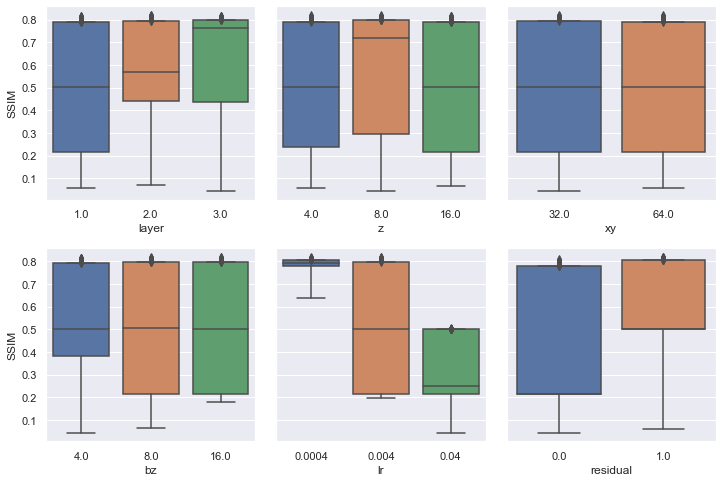

In [42]:
with paperStyle():
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    sns.set()

    for (i,c) in enumerate(cols[:-5]):
        ax = fig.add_subplot(2, 3, i+1)
        sns.boxplot(x=c, y="SSIM", data=df, whis=[0,1], ax=ax)

        #sns.stripplot(data=df, x=c, y='SSIM')# hue= 'SSIM'
        #ax.set_ylim(0,1)
        if not(i ==0 or i==3):
             ax.set_yticklabels([])
             ax.set_ylabel('')
        # if c == 'lr':
        #     ax.set_xscale('log')
        # if c== 'xy' or c == 'bz' or c=='z':
        #     # ax.set_xticks(np.arange(1, len(labels) + 1))
        #     # ax.set_xticklabels(labels)
        #     ax.set_xscale('log',base=2)
        # if c=='residual':
        #     ax.set_xticks(range(2), ['False', 'True'])
        #     ax.set_xlim(-0.2,1.2)
        # if c=='xy':
        #     ax.set_xlim(28,72)
        # if c=='lr':
        #     ax.set_xticks([0.0004,0.004,0.04], ['0.0004', '0.004', '0.04'])
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
plt.savefig('CARE_Hyp.svg')
plt.savefig('CARE_Hyp.pdf')

In [11]:
df_reduced =df.drop('PSNR', 1)
df_reduced =df_reduced.drop('Counter', 1)
df_reduced =df_reduced.drop('Invalid', 1)
df_reduced =df_reduced.drop('MSE', 1)
#df_reduced = df_reduced[~(df_reduced['SSIM'] <= 0.8)]  

C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/2135383987.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_reduced =df.drop('PSNR', 1)
C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/2135383987.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_reduced =df_reduced.drop('Counter', 1)
C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/2135383987.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_reduced =df_reduced.drop('Invalid', 1)
C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/2135383987.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_reduced =df_reduced.drop('MSE', 1)


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_reduced.sort_values('SSIM', 0, ascending=False)
)

     layer     z    xy    bz      lr  residual      SSIM
140    2.0   4.0  64.0  16.0  0.0040       1.0  0.819244
156    2.0   8.0  32.0  16.0  0.0004       1.0  0.818742
8      1.0   4.0  32.0   8.0  0.0040       1.0  0.816357
186    2.0  16.0  32.0   8.0  0.0004       1.0  0.816168
180    2.0  16.0  32.0   4.0  0.0004       1.0  0.815364
36     1.0   8.0  32.0   4.0  0.0004       1.0  0.815135
276    3.0   8.0  64.0   8.0  0.0004       1.0  0.814686
314    3.0  16.0  64.0   8.0  0.0040       1.0  0.814665
258    3.0   8.0  32.0   8.0  0.0004       1.0  0.814431
192    2.0  16.0  32.0  16.0  0.0004       1.0  0.813294
80     1.0  16.0  32.0   8.0  0.0040       1.0  0.812860
272    3.0   8.0  64.0   4.0  0.0040       1.0  0.812456
290    3.0  16.0  32.0   4.0  0.0040       1.0  0.812427
42     1.0   8.0  32.0   8.0  0.0004       1.0  0.812312
132    2.0   4.0  64.0   8.0  0.0004       1.0  0.812103
294    3.0  16.0  32.0   8.0  0.0004       1.0  0.811519
288    3.0  16.0  32.0   4.0  0

C:\Users\jo77pihe\AppData\Local\Temp/ipykernel_18684/2413450883.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only



In [15]:
import plotly.express as px
fig = px.parallel_categories(df_reduced, color="SSIM",dimensions=['layer', 'z', 'xy', 'lr', 'residual'], labels={
                "layer": "n_layers", "z": "patch_size z",
                "xy": "patch_size xy", "bz": "Batch size", "lr": "Learning rate","residual": "Residual",})
fig.update_coloraxes(cmax=1)
fig.update_coloraxes(cmin=0)
fig.write_image("Care_hyp_tuning_res.pdf")
fig.write_image("Care_hyp_tuning_res.svg")
fig.write_image("Care_hyp_tuning_res.png")

In [16]:
fig.show()

In [18]:
df_p = df.pivot("bz", "lr", "SSIM")
sns.heatmap(df_p, vmin=0, vmax=1)

ValueError: Index contains duplicate entries, cannot reshape